In [125]:
import pandas as pd
import numpy as np
import re
import os

# Webscraping/NLP
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import nltk
import requests
import unicodedata
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.colors as mcolors

# Stats
import scipy.stats as stats
from scipy.stats import ttest_ind, levene, f_oneway

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

# My imports
import prepare as p
import acquire as a
from importlib import reload
import explore as e

In [2]:
#Get the data
df = pd.read_pickle('data/michelin_df.pickle')
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [3]:
# # Turn NaN values in price to nothing, so that it can be recast into the price_level column
# df['price'] = df['price'].fillna('').astype('str')

In [4]:
# #Casting a new column, price level, using length of column
# df['price_level'] = df['price'].apply(lambda x: len(x))

In [5]:
# #Setting mode of this column
# mode= df.price_level.mode()[0]
# mode

In [6]:
# #Imputing 0s in price level with the mode for this column
# df['price_level'] = df['price_level'].replace(0, mode)

In [7]:
# #splitting location columns into two columns
# df[['city', 'country']] = df['location'].str.split(',', 1, expand=True)

In [8]:
# #Dropping phone number column
# df = df.drop(['phone_number'], axis=1)

In [9]:
# #Dropping website url column
# df = df.drop(['website_url'], axis=1)

In [10]:
# #lower case all column values if column is object/string type
# df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [11]:
# #Turn city/states into city states, impute city into country column
# df['country'] = np.where(pd.isna(df['country']), df['city'], df['country'])

In [12]:
# def create_features(df):
#     '''
#     This function takes in the dataframe, drops unnecessary columns,
#     and creates new columns/features for exploration and potential
#     classification purposes. It returns the dataframe with applications
#     '''
#     # Dropping unnecessary columns
#     df = df.drop(['phone_number', 'website_url'], axis=1)
    
#     #lower case all column values if column is object/string type
#     df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
    
#     # Turn NaN values in price to 'nothing', so that it can be recast into the price_level column
#     df['price'] = df['price'].fillna('').astype('str')
#     # Casting a new column, price level, using length of column
#     df['price_level'] = df['price'].apply(lambda x: len(x))
#     # impute price level "0" with the mode for this column
#     mode= df.price_level.mode()[0]
#     df['price_level'] = df['price_level'].replace(0, mode)
    
#     # splitting location columns into two columns
#     df[['city', 'country']] = df['location'].str.split(', ', 1, expand=True)
#     # Turn city/states into city states, impute city into country column (i.e Hong Kong, Hong Kong)
#     df['country'] = np.where(pd.isna(df['country']), df['city'], df['country'])

#     return df


In [13]:
# Split and prep data
train, validate, test = p.prepare_michelin(df)

In [14]:
train.head()

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9648,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9618,35
5217,yang bao bao (nanzih),"106 chaoming road, nanzih district, kaohsiung,...","kaohsiung, taipei & taichung",$,dumplings,120.328050,22.724160,https://guide.michelin.com/en/kaohsiung-region...,bib gourmand,"air conditioning,car park,cash only","in 1993, this dumpling shop began life as a st...",1,kaohsiung,taipei & taichung,1993 dumpling shop began life street stall loc...,1993 dumpling shop began life street stall loc...,0.6908,49
3858,le bistrot gastronómico,"temprado 12, castelló de la plana, 12002, spain","castelló de la plana, spain",€€,fusion,-0.037028,39.983588,https://guide.michelin.com/en/comunidad-valenc...,bib gourmand,"air conditioning,american express credit card,...","an unpretentious, friendly and informal restau...",2,castelló de la plana,spain,unpretentious friendly informal whose aim prov...,unpretentious friendly informal whose aim prov...,0.9246,49
124,fat duck,"high street, bray, sl6 2aq, united kingdom","bray, united kingdom",££££,creative,-0.701753,51.507858,https://guide.michelin.com/en/windsor-and-maid...,3 michelin stars,"air conditioning,american express credit card,...",this iconic restaurant celebrated its 25-year ...,4,bray,united kingdom,iconic celebrated 25year anniversary 2021 intr...,iconic celebrated 25year anniversary 2021 intr...,0.9686,40


In [15]:
# df[df.data == 'None']

In [16]:
#Code for removing former michelin restaurants still in df
# df = df[df.data != 'None']

In [17]:
# # Creating column with length of clean words
# df['lemm_wordcount'] = df.lemmatized.str.split().apply(len)

In [18]:
#Making an empty list of words
words = []
for i in train['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        words.append(word) #appending each word to the list

In [19]:
#Turning into series based on value counts
word_freq = pd.Series(words).value_counts()

In [20]:
word_freq.sort_values(ascending=False).head(50)

dish            1954
ingredient      1183
also             997
flavour          969
wine             957
'                867
modern           831
room             778
kitchen          713
one              661
local            655
food             582
fish             580
set              565
cooking          552
produce          541
sauce            523
traditional      523
like             480
served           471
offer            470
make             469
culinary         465
take             457
two              454
well             453
table            450
classic          449
service          448
seasonal         440
experience       436
made             402
terrace          402
come             398
guest            395
menu             391
pork             390
la               390
team             388
rice             386
small            385
name             383
elegant          380
feature          380
fine             375
meat             372
contemporary     369
vegetable    

In [21]:
word_freq.sort_values(ascending=False).tail(50)

daechuns            1
diversify           1
rekindles           1
booklet             1
seesawing           1
beuscherl           1
backlikely          1
weekfor             1
kojacha             1
ja                  1
nimble              1
lima                1
barranco            1
kreis               1
luck                1
mit                 1
fiveskewer          1
serviettenknodel    1
berdin              1
jennifer            1
banagale            1
driver              1
sanctum             1
pacing              1
rudderfish          1
tosazu              1
vealandpork         1
lemonbe             1
ciccio              1
1916era             1
ciboule             1
loco                1
malo                1
chouin              1
snub                1
castelbrac          1
charcot             1
seaman              1
polar               1
dinan               1
hennote             1
polynesia           1
professes           1
pirate              1
eraand              1
yeongdu   

In [22]:
#Make dataframes by award category
train_bib = train[train.award == 'bib gourmand']
train_onestar = train[train.award == '1 michelin star']
train_twostar = train[train.award == '2 michelin stars']
train_threestar = train[train.award == '3 michelin stars']

In [23]:
#Making a list of bib words
bib_words = []
for i in train_bib['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        bib_words.append(word) #appending each word to the list
        
#Making a list of one star words
onestar_words = []
for i in train_onestar['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        onestar_words.append(word) #appending each word to the list

#Making a list of two star words
twostar_words = []
for i in train_twostar['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        twostar_words.append(word) #appending each word to the list

#Making a list of three star words
threestar_words = []
for i in train_threestar['lemmatized']:
    for word in i.split(): #Splitting the sentence into words
        threestar_words.append(word) #appending each word to the list

In [24]:
#Turning into series based on value counts
bib_freq = pd.Series(bib_words).value_counts()
onestar_freq = pd.Series(onestar_words).value_counts()
twostar_freq = pd.Series(twostar_words).value_counts()
threestar_freq = pd.Series(threestar_words).value_counts()

In [25]:
#Frequency of bib gourmand words
print(bib_freq.nlargest(25))

dish           820
also           420
flavour        339
'              332
pork           331
ingredient     323
food           322
room           317
sauce          316
traditional    315
local          312
wine           296
modern         272
rice           257
like           255
noodle         252
fish           251
kitchen        250
cooking        245
offer          243
chicken        242
soup           231
made           222
one            221
meat           218
dtype: int64


In [26]:
#Frequency of one star words
print(onestar_freq.nlargest(25))

dish          908
ingredient    694
wine          566
flavour       497
also          474
modern        468
'             396
kitchen       387
room          385
one           364
produce       316
local         302
set           295
experience    269
culinary      265
cooking       257
fish          256
guest         256
elegant       255
take          254
menu          252
tasting       251
service       240
served        233
creative      231
dtype: int64


In [27]:
#Frequency of two star words
print(twostar_freq.nlargest(25))

dish          167
ingredient    124
'             112
flavour        95
also           86
wine           77
modern         76
set            69
fish           64
culinary       62
kitchen        62
creative       60
team           59
room           58
produce        58
chef           54
one            51
fine           50
elegant        50
vegetable      49
experience     43
table          42
service        42
view           41
menu           41
dtype: int64


In [28]:
#Frequency of three star words
print(threestar_freq.nlargest(25))

dish          59
ingredient    42
flavour       38
service       29
'             27
experience    27
culinary      25
one           25
team          20
make          18
wine          18
room          18
also          17
elegant       15
setting       15
tasting       15
modern        15
always        15
cooking       15
superb        14
kitchen       14
set           14
diner         14
come          14
work          14
dtype: int64


In [29]:
# What are the countries with the most Michelin Star Restaurants?
train.country.value_counts()

france               573
japan                474
italy                385
usa                  336
germany              335
spain                285
switzerland          151
belgium              143
united kingdom       142
netherlands          128
china mainland       121
thailand             121
taipei & taichung     99
hong kong             71
singapore             70
south korea           49
portugal              40
brazil                27
denmark               27
canada                22
ireland               20
malaysia              19
austria               18
croatia               14
slovenia              13
sweden                12
dubai                 12
macau                 10
luxembourg            10
norway                 9
hungary                9
türkiye                8
greece                 7
malta                  6
finland                6
czech republic         5
abu dhabi              5
estonia                4
poland                 4
iceland                2


In [30]:
df.award.value_counts()

Bib Gourmand        3411
1 MICHELIN Star     2744
2 MICHELIN Stars     483
3 MICHELIN Stars     142
Name: award, dtype: int64

In [31]:
def get_award_freq(train):
    '''
    This function takes in the training data set and creates a countplot
    utilizing Seaborn to visualize the range and values of programming
    languages in GitHub Repositories'''
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(figsize=(9, 6))
    cpt = sns.countplot(x='award',
                        data=train,
                        palette='RdYlGn_r',
                        order = train['award'].value_counts().index)
    plt.title('Bib Gourmand is the Most Common Award Level in our Dataset')
    plt.xlabel("Award Level")
    plt.ylabel('Count of Restaurants')
    for tick in axes.xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    plt.show()

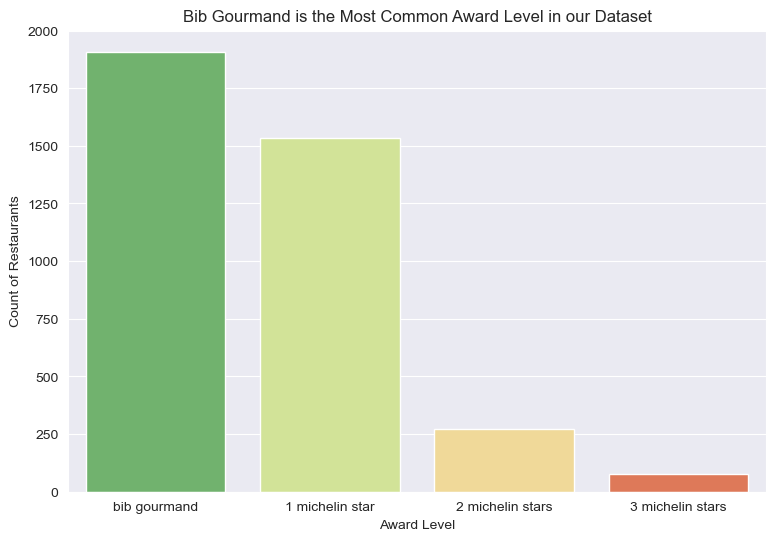

In [32]:
e.get_award_freq(train)

In [33]:
def get_wordcount_bar(train):
    '''
    This function takes in the training dataset and creates a bar plot of the
    average wordcount of a review based on the Michelin Star Award
    '''
    # Use groupby to get an average length per language
    review_wordcount = train.groupby('award').word_count.mean().sort_values(ascending=False)
    # Set style, make a chart
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(figsize=(9, 6))
    ax = sns.barplot(x=review_wordcount.values, 
                 y=review_wordcount.index, palette='coolwarm')
    plt.title('Average Wordcount of Michelin Star Level Restaurants')
    plt.xlabel("Average Word Count")
    plt.ylabel('Award Level')
    plt.show()

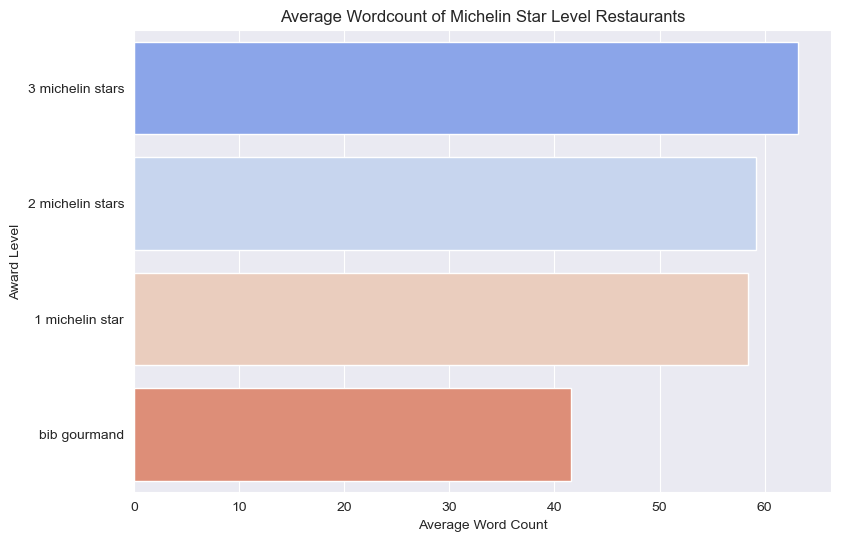

In [34]:
e.get_wordcount_bar(train)

In [35]:
def top_10_country_viz(train):
    '''
    This function takes in the training dataset and creates a bar plot of the
    top 10 countries with Michelin restaurants
    '''
    # Use groupby to get an average length per language
    top_10_countries = train['country'].value_counts().head(10)
    # Set style, make a chart
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(figsize=(9, 6))
    ax = sns.barplot (x=top_10_countries.index,
                      y=top_10_countries.values,
                      palette='mako')
    plt.title('Countries with the Most Michelin Restaurants')
    plt.xlabel("Countries")
    plt.ylabel('Number of Restaurants')
    plt.show()

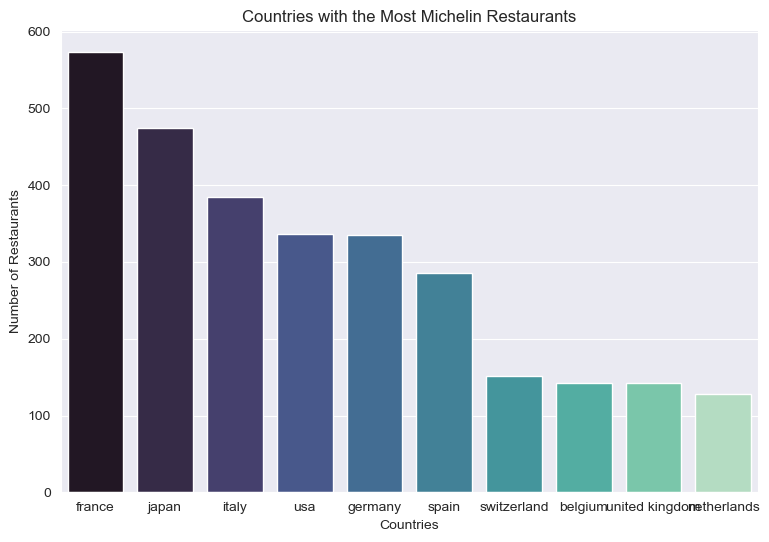

In [36]:
e.top_10_country_viz(train)

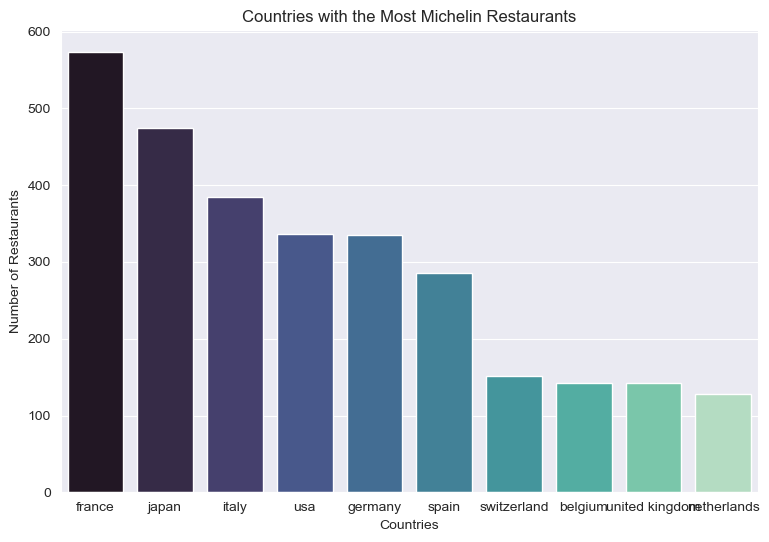

In [37]:
e.top_10_country_viz(train)

In [38]:
# Mean word count of each 
print(f'Average Bib Gourmand Word Length is : {train_bib.word_count.mean()}')
print(f'Average Michelin One Star Word Length is : {train_onestar.word_count.mean()}')
print(f'Average Michelin Two Star Word Length is : {train_twostar.word_count.mean()}')
print(f'Average Michelin Three Star Word Length is : {train_threestar.word_count.mean()}')

Average Bib Gourmand Word Length is : 41.574947589098535
Average Michelin One Star Word Length is : 58.432942708333336
Average Michelin Two Star Word Length is : 59.22222222222222
Average Michelin Three Star Word Length is : 63.177215189873415


In [39]:
def get_anova_wordcount(train):
    '''
    This function creates separate dataframes for
    each award category, and utilizes an ANOVA test
    to compare the mean word count of each category. It
    returns the test statistic, p-value, and treatment
    of the null hypothesis
    '''
    # Create separate df for each category
    train_bib = train[train.award == 'bib gourmand']
    train_onestar = train[train.award == '1 michelin star']
    train_twostar = train[train.award == '2 michelin stars']
    train_threestar = train[train.award == '3 michelin stars']
    # set alpha
    alpha = 0.05
    # Run the test
    f, p = stats.f_oneway(train_bib.word_count, train_onestar.word_count,
                 train_twostar.word_count, train_threestar.word_count)
    if p < alpha:
        print("We reject the null hypothesis. There is sufficient \n\
            evidence to conclude that the word count is significantly \n\
                different between award categories.")
    else:
        print("We fail to reject the null hypothesis.")
    return print(f'Test Statistic: {f}, P Statistic: {p}')
    
    

In [40]:
# Running anova between award categories (word count)
e.get_anova_wordcount(train)

We reject the null hypothesis. There is sufficient
evidence to conclude that the word count is significantly
different between award categories.
Test Statistic: 324.58867718184115, P Statistic: 1.4373128353659552e-187


# Modeling Using features

In [41]:
# Get clean data
df = a.get_michelin_pages()

In [42]:
# Prep the data
train, validate, test = p.prepare_michelin(df)
train.head(2)

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9648,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9618,35


In [43]:
# #Getting top three countries for modeling

# top_three_countries = train['country'].value_counts().nlargest(3).index.tolist()
# top_three_countries

In [44]:
# #This only made a separate df
# country_dummies = pd.get_dummies(train[train['country'].isin(top_three_countries)], columns=['country'])

In [45]:
# train.country.value_counts().head(5)

In [46]:
# #convert countries to dummy variable
# pd.get_dummies(train, columns=['country'], drop_first=False)

In [47]:
# # Keep only the columns we need for modeling
# columns_to_keep = ['sentiment', 'word_count', 'price_level_1', 'price_level_2', 'price_level_3', 'price_level_4',
#                    'country_france', 'country_japan', 'country_italy', 'country_usa', 'country_germany']
                   

In [48]:
# dummy_df = pd.get_dummies(train, columns=['country', 'price_level'], drop_first=False)

# # Add the dummy variables to the original dataframe
# train = train.assign(**dummy_df)
# train.head()

In [49]:
# def prep_classification_data(train, validate, test):
#     '''
#     This function takes in train, validate, and test and returns
#     train, validate, and test prepped for classification modeling
#     '''
#     # Impute NaN values in sentiment with the mean
#     train['sentiment'].fillna(int(train['sentiment'].mean()), inplace=True)
#     validate['sentiment'].fillna(int(validate['sentiment'].mean()), inplace=True)
#     test['sentiment'].fillna(int(test['sentiment'].mean()), inplace=True)
#     # Create dummy columns
#     dummy_train = pd.get_dummies(train, columns=['country', 'price_level'], drop_first=False)
#     dummy_validate = pd.get_dummies(validate, columns=['country', 'price_level'], drop_first=False)
#     dummy_test = pd.get_dummies(test, columns=['country', 'price_level'], drop_first=False)
#     # Add the dummy variables to the original dataframe
#     train = train.assign(**dummy_train)
#     validate = validate.assign(**dummy_validate)
#     test = test.assign(**dummy_test)
#     # Keep only the columns we need for modeling
#     columns_to_keep = ['award', 'sentiment', 'word_count', 'price_level_1', 'price_level_2',
#                        'price_level_3', 'price_level_4', 'country_france', 'country_japan',
#                        'country_italy', 'country_usa', 'country_germany']
#     train = train[columns_to_keep]
#     validate = validate[columns_to_keep]
#     test = test[columns_to_keep]
    
#     return train, validate, test

In [50]:
reload(p)
train, validate, test = p.prep_classification_data(train, validate, test)

In [51]:
# Creating x and y version of train
X_train = train.drop(columns=['award'])
y_train = train.award

X_validate = validate.drop(columns=['award'])
y_validate = validate.award

X_test = test.drop(columns=['award'])
y_test = test.award

### Decision Tree

In [52]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.
# Create the object
clf = DecisionTreeClassifier(max_depth=4, random_state=123)
# Fit the model
clf = clf.fit(X_train, y_train)

In [53]:
# make prediction on train obeservations
y_pred = clf.predict(X_train)

In [54]:
y_pred[0:5]

array(['bib gourmand', 'bib gourmand', 'bib gourmand', 'bib gourmand',
       '1 michelin star'], dtype=object)

In [55]:
# Estimate Probability
y_pred_proba = clf.predict_proba(X_train)


In [56]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.88


In [57]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[1477,    0,    0,   59],
       [ 265,    0,    0,    5],
       [  79,    0,    0,    0],
       [  35,    0,    0, 1873]])

In [58]:
y_train.value_counts()

bib gourmand        1908
1 michelin star     1536
2 michelin stars     270
3 michelin stars      79
Name: award, dtype: Int64

In [59]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,1 michelin star,2 michelin stars,3 michelin stars,bib gourmand
1 michelin star,1477,0,0,59
2 michelin stars,265,0,0,5
3 michelin stars,79,0,0,0
bib gourmand,35,0,0,1873


In [60]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

 1 michelin star       0.80      0.96      0.87      1536
2 michelin stars       0.00      0.00      0.00       270
3 michelin stars       0.00      0.00      0.00        79
    bib gourmand       0.97      0.98      0.97      1908

        accuracy                           0.88      3793
       macro avg       0.44      0.49      0.46      3793
    weighted avg       0.81      0.88      0.84      3793



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [61]:
# Now trying with Random Forest
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [62]:
X_train.head()

,sentiment,word_count,price_level_1,price_level_2,price_level_3,price_level_4,country_france,country_japan,country_italy,country_usa,country_germany
6345,0.9648,38,1,0,0,0,0,0,0,0,1
6427,0.9618,35,1,0,0,0,0,0,0,0,1
5217,0.6908,49,1,0,0,0,0,0,0,0,0
3858,0.9246,49,0,1,0,0,0,0,0,0,0
124,0.9686,40,0,0,0,1,0,0,0,0,0


In [63]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [64]:
print(rf.feature_importances_)

[0.02034211 0.08573082 0.17601746 0.33897388 0.19304202 0.17006745
 0.0019108  0.00155479 0.00226077 0.0078082  0.00229169]


In [65]:
# Make predictions
y_pred = rf.predict(X_train)

In [66]:
# Estimate the probability
y_pred_proba = rf.predict_proba(X_train)

In [67]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.88


In [68]:
print(confusion_matrix(y_train, y_pred))

[[1465    0    0   71]
 [ 265    0    0    5]
 [  79    0    0    0]
 [  28    0    0 1880]]


In [69]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

 1 michelin star       0.80      0.95      0.87      1536
2 michelin stars       0.00      0.00      0.00       270
3 michelin stars       0.00      0.00      0.00        79
    bib gourmand       0.96      0.99      0.97      1908

        accuracy                           0.88      3793
       macro avg       0.44      0.48      0.46      3793
    weighted avg       0.81      0.88      0.84      3793



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.89


### K Nearest Neighbors

In [71]:
# Make the object with 6 neighbors
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [72]:
# Fit the object
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [73]:
# Make predictions
y_pred = knn.predict(X_train)

In [74]:
# Estimate proability
y_pred_proba = knn.predict_proba(X_train)

In [75]:
# Compute accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.89


In [76]:
print(confusion_matrix(y_train, y_pred))

[[1429   38    1   68]
 [ 182   82    1    5]
 [  67   10    2    0]
 [  32    0    0 1876]]


In [77]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

 1 michelin star       0.84      0.93      0.88      1536
2 michelin stars       0.63      0.30      0.41       270
3 michelin stars       0.50      0.03      0.05        79
    bib gourmand       0.96      0.98      0.97      1908

        accuracy                           0.89      3793
       macro avg       0.73      0.56      0.58      3793
    weighted avg       0.88      0.89      0.88      3793



In [78]:
print('Accuracy of KNN classifier on validation set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on validation set: 0.87


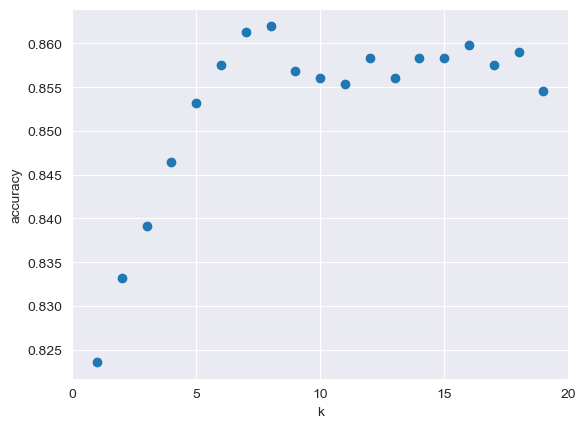

In [79]:
# Visualizae this
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

### Logistic Regression

In [80]:
# Need to scale features for this model (Sentiment and Word Count)
train.head(2)

,award,sentiment,word_count,price_level_1,price_level_2,price_level_3,price_level_4,country_france,country_japan,country_italy,country_usa,country_germany
6345,bib gourmand,0.9648,38,1,0,0,0,0,0,0,0,1
6427,bib gourmand,0.9618,35,1,0,0,0,0,0,0,0,1


In [81]:
# Creating x and y version of train
X_train = train.drop(columns=['award'])
y_train = train.award

X_validate = validate.drop(columns=['award'])
y_validate = validate.award

X_test = test.drop(columns=['award'])
y_test = test.award

In [82]:
# # Select the columns you want to scale
# columns_to_scale = ['sentiment', 'word_count']


# # Fit the scaler to the selected columns
# X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
# X_validate[columns_to_scale] = scaler.fit_transform(X_validate[columns_to_scale])
# X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

# # The selected columns are now scaled

In [83]:
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(multi_class = 'multinomial', random_state=123, solver='lbfgs')

In [84]:
logit.fit(X_train, y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=123)

In [85]:
# Examine feature importance
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 0.13005568  0.01391819 -2.20963688 -0.09531458  1.713296    0.93575618
  -0.08042017 -0.39975995  0.51698767 -0.50831381 -0.03770959]
 [ 0.20292408  0.01219348 -1.35037614 -1.37995726  0.14859157  1.51662846
  -0.41511167  0.67037861 -0.44598601 -1.05298857 -0.27422175]
 [-0.94107931  0.01874305 -0.80206151 -1.13749731 -0.78528759  1.22218925
  -0.0422149   0.23962602 -0.09689176 -0.29458624 -0.12479241]
 [ 0.60809956 -0.04485472  4.36207453  2.61276915 -1.07659998 -3.67457389
   0.53774675 -0.51024468  0.0258901   1.85588861  0.43672375]]
Intercept: 
 [ 0.33912912 -1.15468767 -1.59248516  2.40804371]


In [86]:
# Make Predictions
y_pred = logit.predict(X_train)

In [87]:
# Estimate Probability
y_pred_proba = logit.predict_proba(X_train)

In [88]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.88


In [89]:
print(confusion_matrix(y_train, y_pred))

[[1442   24    0   70]
 [ 243   22    0    5]
 [  67   12    0    0]
 [  28    0    0 1880]]


In [90]:
print(classification_report(y_train, y_pred))

                  precision    recall  f1-score   support

 1 michelin star       0.81      0.94      0.87      1536
2 michelin stars       0.38      0.08      0.13       270
3 michelin stars       0.00      0.00      0.00        79
    bib gourmand       0.96      0.99      0.97      1908

        accuracy                           0.88      3793
       macro avg       0.54      0.50      0.49      3793
    weighted avg       0.84      0.88      0.85      3793



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
# Make predicion on validate
y_pred_validate = logit.predict(X_validate)

In [92]:
# accuracy of model on validate
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

Accuracy: 0.88


In [93]:
# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred_validate))

[[625   9   0  24]
 [108   6   0   2]
 [ 31   3   0   0]
 [ 11   0   0 807]]


In [94]:
# classification report of model 1
print(classification_report(y_validate, y_pred_validate))

                  precision    recall  f1-score   support

 1 michelin star       0.81      0.95      0.87       658
2 michelin stars       0.33      0.05      0.09       116
3 michelin stars       0.00      0.00      0.00        34
    bib gourmand       0.97      0.99      0.98       818

        accuracy                           0.88      1626
       macro avg       0.53      0.50      0.48      1626
    weighted avg       0.84      0.88      0.85      1626



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


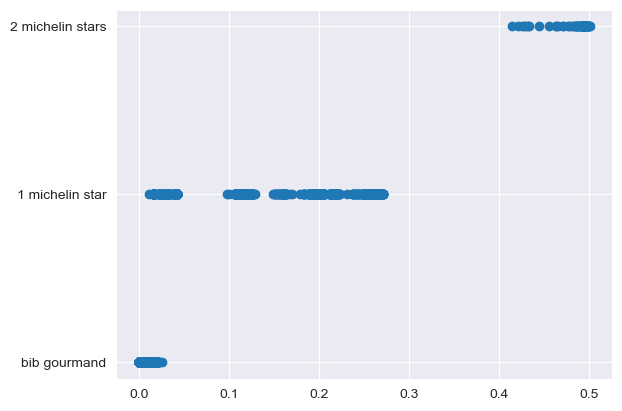

In [95]:
# create array of probabilities

y_pred_proba = np.array([i[1] for i in y_pred_proba])
fig = plt.figure()
ax = fig.add_subplot(111)

# scatter plot where x is the probabilities and y is the class (0, 1)
ax.scatter(y_pred_proba, y_pred)

## Wordclouds

In [ ]:
# Three-star Reviews

In [98]:
train_bib.head(2)

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9648,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9618,35


In [99]:
all_threestar_words = ' '.join(train_threestar['lemmatized'])
all_twostar_words = ' '.join(train_twostar['lemmatized'])
all_onestar_words = ' '.join(train_onestar['lemmatized'])
all_bib_words = ' '.join(train_bib['lemmatized'])

In [104]:
print(f'Three star reviews have {len(all_threestar_words)} words')
print(f'Two star reviews have {len(all_twostar_words)} words')
print(f'One star reviews have {len(all_onestar_words)} words')
print(f'Bib Gourmand reviews have {len(all_bib_words)} words')

Three star reviews have 37836 words
Two star reviews have 119526 words
One star reviews have 669572 words
Bib Gourmand reviews have 573311 words


In [120]:
#all_threestar_words
#all_twostar_words
#all_onestar_words
#all_bib_words

In [121]:
#File path to directory
#/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/

In [122]:
# # Write all words for each review category to text files

# # Write all threestar text to readme
# text_file = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_threestar_words.txt', 'w')
# text_file.write(all_threestar_words)
# text_file.close()

# #Two star
# text_file = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_twostar_words.txt', 'w')
# text_file.write(all_twostar_words)
# text_file.close()

# # One star
# text_file = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_onestar_words.txt', 'w')
# text_file.write(all_onestar_words)
# text_file.close()

# #Bib Gourmand
# text_file = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_bib_words.txt', 'w')
# text_file.write(all_bib_words)
# text_file.close()

In [124]:
#Creating text for wordclouds
threestar_text = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_threestar_words.txt',
            mode='r', encoding='utf-8').read()
twostar_text = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_twostar_words.txt',
            mode='r', encoding='utf-8').read()
onestar_text = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_onestar_words.txt',
            mode='r', encoding='utf-8').read()
bib_text = open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/all_bib_words.txt',
            mode='r', encoding='utf-8').read()

In [127]:
#Import .png file of three star logo to test this out
mask = np.array(Image.open(r'/Users/crislucin/codeup-data-science/Michelin_NLP_Capstone/images/three_stars.png'))

In [128]:
# replace 0 with 255
mask[mask == 0] = 255
mask

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [131]:
#Making the wordcloud

wc = WordCloud(
               mask = mask, background_color = "black",
               max_words = 200, max_font_size = 500,
               random_state = 42, width = mask.shape[0], colormap='YlGnBu',
               height = mask.shape[1])

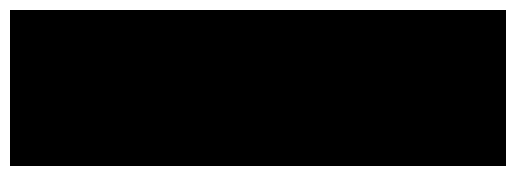

In [132]:
wc.generate(threestar_text)
plt.imshow(wc, interpolation="None")
plt.axis('off')
plt.show()

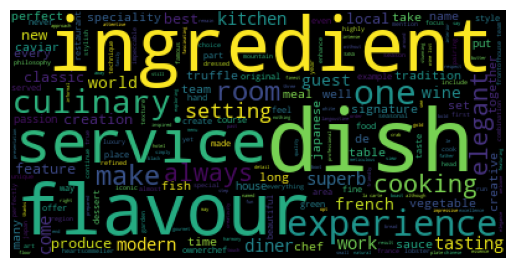

In [136]:
#Give our Three star corpus a variable name
#three_star_words

#Instantiate wordcloud object and use method to feed it our corpus
wc = WordCloud().generate_from_text(all_threestar_words)

#Use matplotlib.pyplot to display the fitted wordcloud
#Turn axis off to get rid of axis numbers
plt.imshow(wc)
plt.axis('off')
plt.show()

In [154]:
#Define a list of stop words
stopwords = ["there", "dish", "ingredient", "flavour", "also", "wine", "culinary", "cooking"]

#A function to generate the word cloud from text
def generate_basic_wordcloud(data, title):
    cloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stopwords,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(9,7))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.show()

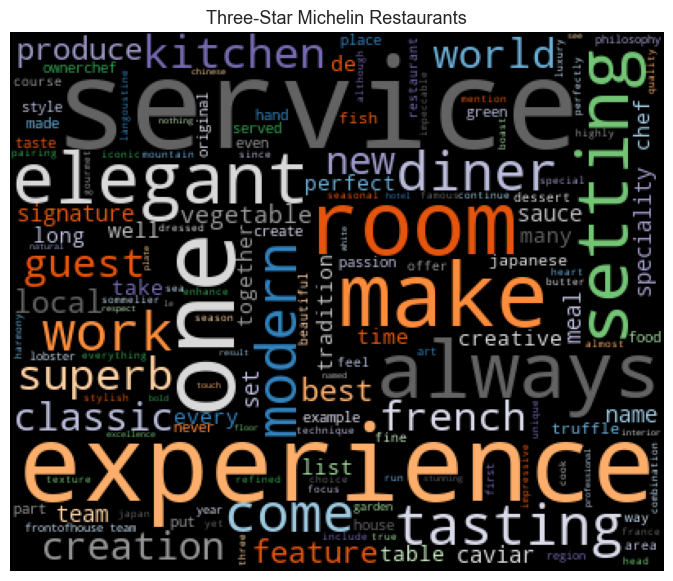

In [155]:
    
#Use the function to generate the word cloud
generate_basic_wordcloud(all_threestar_words, 'Three-Star Michelin Restaurants')

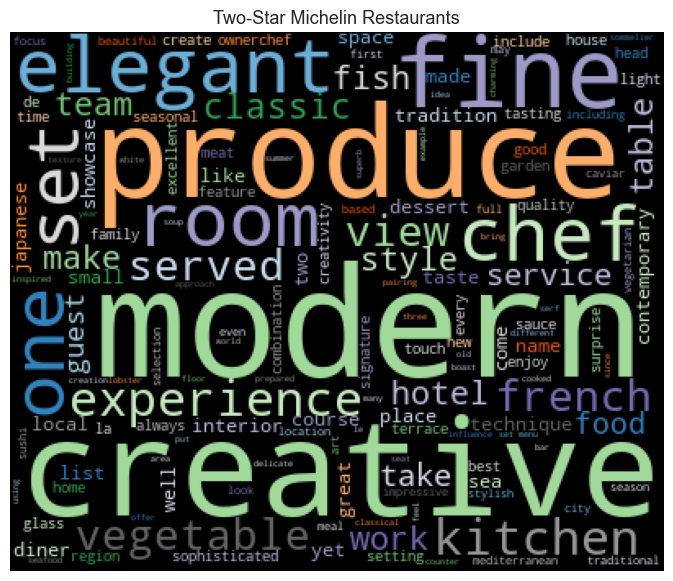

In [157]:
generate_basic_wordcloud(all_twostar_words, 'Two-Star Michelin Restaurants')

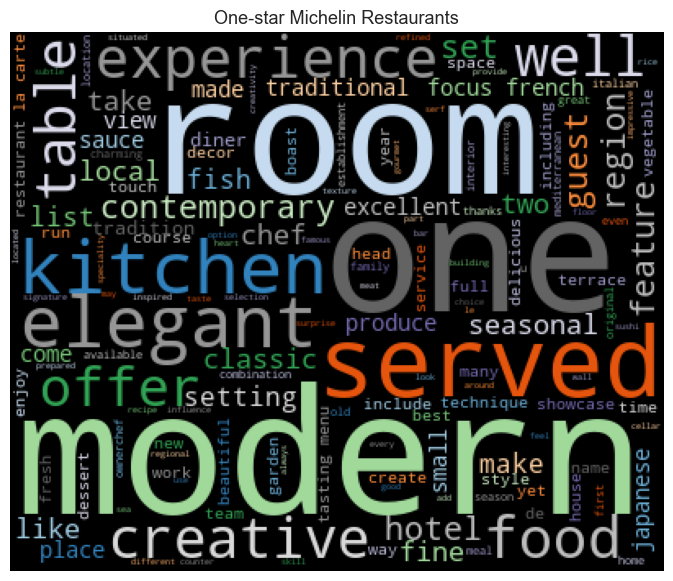

In [158]:
generate_basic_wordcloud(all_onestar_words, "One-star Michelin Restaurants")

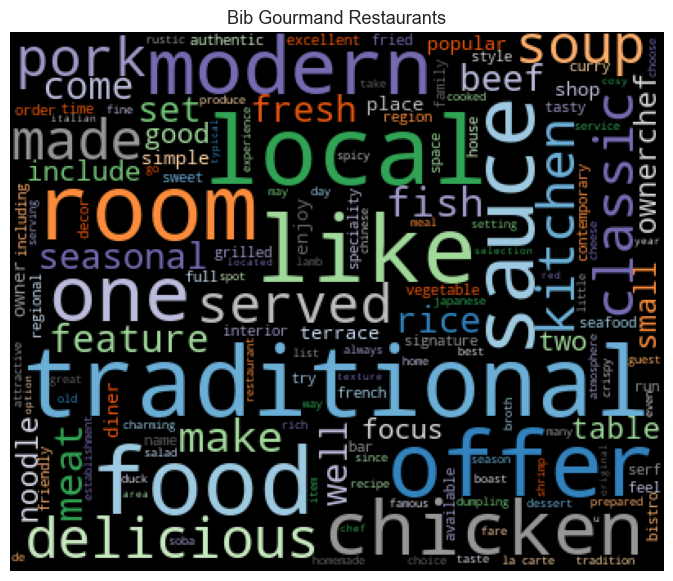

In [160]:
generate_basic_wordcloud(all_bib_words, 'Bib Gourmand Restaurants')